In [1]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
import seaborn as sb  
from scipy.io import loadmat  
%matplotlib inline

In [2]:
data = loadmat('data/ex8data1.mat')  
X = data['X']  
X.shape

(307, 2)

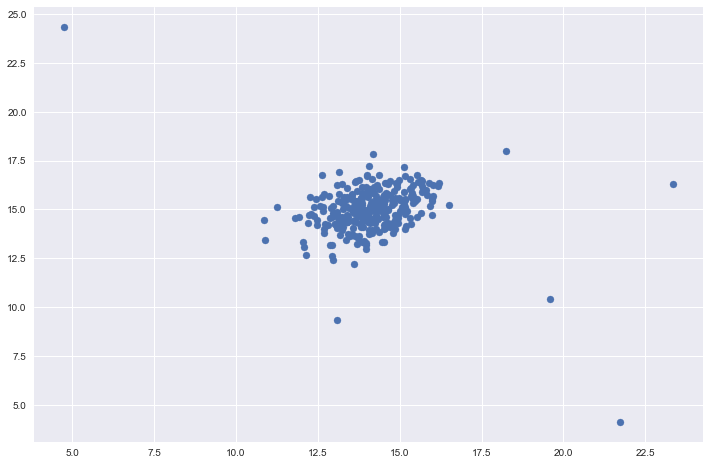

In [3]:
fig, ax = plt.subplots(figsize=(12,8))  
ax.scatter(X[:,0], X[:,1])  

In [4]:
def estimate_gaussian(X):  
    mu = X.mean(axis=0)
    sigma = X.var(axis=0)

    return mu, sigma

In [5]:
mu, sigma = estimate_gaussian(X)
mu, sigma

(array([ 14.11222578,  14.99771051]), array([ 1.83263141,  1.70974533]))

In [6]:
Xval = data['Xval']  
yval = data['yval']

In [8]:
Xval.shape, yval.shape

((307, 2), (307, 1))

Check that data pt belongs to normal distrib

In [9]:
from scipy import stats  
dist = stats.norm(mu[0], sigma[0]) # normal distribution w/ these parms
dist.pdf(X[:,0])[0:50] # get PDF--probabilities that the first 50 instances of X's first dim belong to above normal distribution

array([ 0.183842  ,  0.20221694,  0.21746136,  0.19778763,  0.20858956,
        0.21652359,  0.16991291,  0.15123542,  0.1163989 ,  0.1594734 ,
        0.21716057,  0.21760472,  0.20141857,  0.20157497,  0.21711385,
        0.21758775,  0.21695576,  0.2138258 ,  0.21057069,  0.1173018 ,
        0.20765108,  0.21717452,  0.19510663,  0.21702152,  0.17429399,
        0.15413455,  0.21000109,  0.20223586,  0.21031898,  0.21313426,
        0.16158946,  0.2170794 ,  0.17825767,  0.17414633,  0.1264951 ,
        0.19723662,  0.14538809,  0.21766361,  0.21191386,  0.21729442,
        0.21238912,  0.18799417,  0.21259798,  0.21752767,  0.20616968,
        0.21520366,  0.1280081 ,  0.21768113,  0.21539967,  0.16913173])

In [10]:
p = np.zeros((X.shape[0], X.shape[1]))  # save prob dens of each value in X given above Gaussian model params
p[:,0] = stats.norm(mu[0], sigma[0]).pdf(X[:,0])
p[:,1] = stats.norm(mu[1], sigma[1]).pdf(X[:,1])

In [11]:
p.shape

(307, 2)

In [12]:
pval = np.zeros((Xval.shape[0], Xval.shape[1])) # for val set
pval[:,0] = stats.norm(mu[0], sigma[0]).pdf(Xval[:,0])
pval[:,1] = stats.norm(mu[1], sigma[1]).pdf(Xval[:,1])

In [13]:
def select_threshold(pval, yval):
    best_epsilon = 0
    best_f1 = 0
    f1 = 0

    step = (pval.max() - pval.min()) / 1000
    
    for epsilon in np.arange(pval.min(), pval.max(), step):
        preds = pval < epsilon
        
        # get true/false positive and false negative
        tp = np.sum(np.logical_and(preds == 1, yval == 1)).astype(float)
        fp = np.sum(np.logical_and(preds == 1, yval == 0)).astype(float)
        fn = np.sum(np.logical_and(preds == 0, yval == 1)).astype(float)
        
        # calculate precision and recall
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = (2 * precision * recall) / (precision + recall)
        
        # update best epsilon
        if f1 > best_f1:
            best_f1 = f1
            best_epsilon = epsilon
            
    return best_epsilon, best_f1

In [14]:
epsilon, f1 = select_threshold(pval, yval)  
epsilon, f1

C:\Python35\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


(0.0095667060059568421, 0.7142857142857143)

In [15]:
# get outlier indexes
outliers = np.where(p < epsilon)

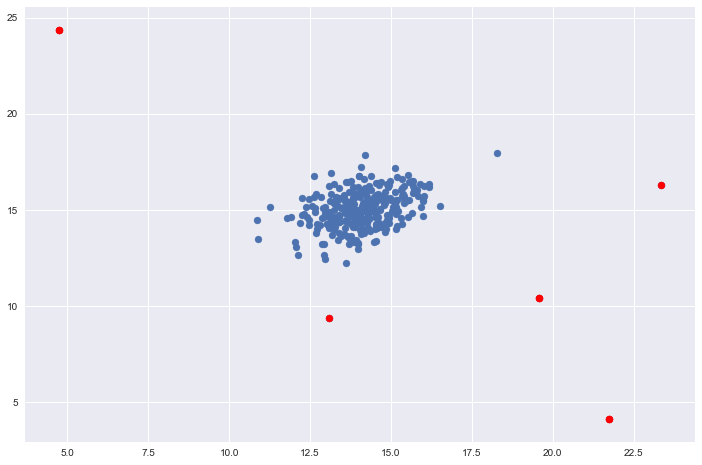

In [16]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(X[:,0], X[:,1])
ax.scatter(X[outliers[0],0], X[outliers[0],1], s=50, color='r', marker='o')

## Collaborative Filtering

In [17]:
data = loadmat('data/ex8_movies.mat')
data

{'R': array([[1, 1, 0, ..., 1, 0, 0],
        [1, 0, 0, ..., 0, 0, 1],
        [1, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'Y': array([[5, 4, 0, ..., 5, 0, 0],
        [3, 0, 0, ..., 0, 0, 5],
        [4, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 '__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Thu Dec  1 17:19:26 2011',
 '__version__': '1.0'}

In [18]:
Y = data['Y'] # array of dim (# movies) x (# users) containing ratings (1-5)
R = data['R'] # indicator array of whether user j rated movie i
Y.shape, R.shape

((1682, 943), (1682, 943))

In [19]:
Y[1,R[1,:]].mean() # get average rating by checking where a user actually rated a film

2.5832449628844114

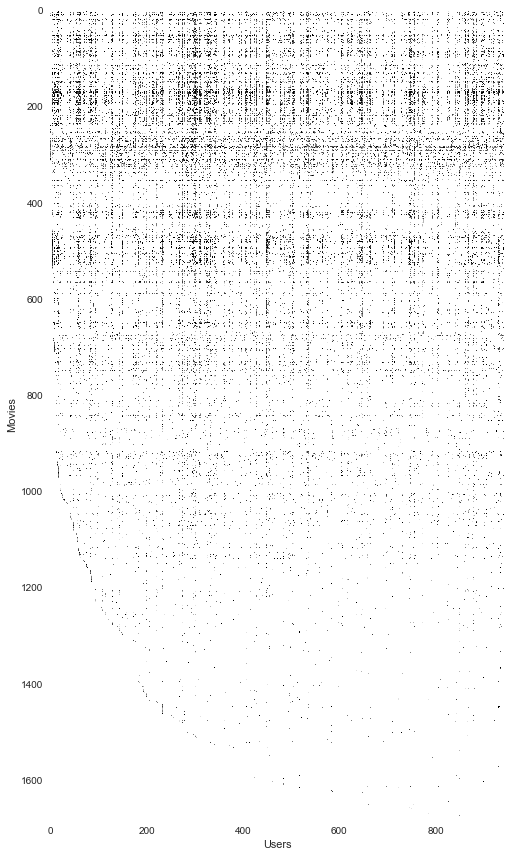

In [20]:
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(Y)
ax.set_xlabel('Users')
ax.set_ylabel('Movies')
fig.tight_layout()

In [21]:
def cost(params, Y, R, num_features):  
    Y = np.matrix(Y)  # (1682, 943)
    R = np.matrix(R)  # (1682, 943)
    num_movies = Y.shape[0]
    num_users = Y.shape[1]
    
    # reshape the parameter array into parameter matrices
    X = np.matrix(np.reshape(params[:num_movies * num_features], (num_movies, num_features)))  # (1682, 10)
    Theta = np.matrix(np.reshape(params[num_movies * num_features:], (num_users, num_features)))  # (943, 10)
    
    # init cost
    cost = 0
    
    # update cost
    error = np.multiply((X * Theta.T) - Y, R)  # (1682, 943)
    squared_error = np.power(error, 2)  # (1682, 943)
    cost = (1. / 2) * np.sum(squared_error)
    
    return cost

In [49]:
users = 4
movies = 5
features = 3

In [50]:
params_data = loadmat('data/ex8_movieParams.mat')  
X = params_data['X']  
Theta = params_data['Theta']

In [51]:
# look at subset
X_sub = X[:movies, :features]  
Theta_sub = Theta[:users, :features]  
Y_sub = Y[:movies, :users]  
R_sub = R[:movies, :users]

In [52]:
params = np.concatenate((np.ravel(X_sub), np.ravel(Theta_sub)))

In [53]:
cost(params, Y_sub, R_sub, features)

TypeError: 'numpy.float64' object is not callable

In [27]:
def cost(params, Y, R, num_features):
    # cost but also compute grads
    Y = np.matrix(Y)  # (1682, 943)
    R = np.matrix(R)  # (1682, 943)
    num_movies = Y.shape[0]
    num_users = Y.shape[1]

    # reshape the parameter array into parameter matrices
    X = np.matrix(np.reshape(params[:num_movies * num_features], (num_movies, num_features)))  # (1682, 10)
    Theta = np.matrix(np.reshape(params[num_movies * num_features:], (num_users, num_features)))  # (943, 10)

    # initializations: cost and gradients
    cost = 0
    X_grad = np.zeros(X.shape)  # (1682, 10)
    Theta_grad = np.zeros(Theta.shape)  # (943, 10)
    
    # cost computation
    error = np.multiply((X * Theta.T) - Y, R)  # (1682, 943)
    squared_error = np.power(error, 2)  # (1682, 943)
    cost = (1. / 2) * np.sum(squared_error)
    
    # grads
    X_grad = error * Theta
    Theta_grad = error.T * X
    
    # put X_grad, Theta_grad into single arr
    grad = np.concatenate((np.ravel(X_grad), np.ravel(Theta_grad)))
    
    return cost, grad

In [28]:
cost, grad = cost(params, Y_sub, R_sub, features)  
cost, grad

(22.224603725685675,
 array([ -2.52899165,   7.57570308,  -1.89979026,  -0.56819597,
          3.35265031,  -0.52339845,  -0.83240713,   4.91163297,
         -0.76677878,  -0.38358278,   2.26333698,  -0.35334048,
         -0.80378006,   4.74271842,  -0.74040871, -10.5680202 ,
          4.62776019,  -7.16004443,  -3.05099006,   1.16441367,
         -3.47410789,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ]))

In [54]:
def cost_reg(params, Y, R, num_features, learning_rate):
    # regularized cost
    Y = np.matrix(Y)  # (1682, 943)
    R = np.matrix(R)  # (1682, 943)
    num_movies = Y.shape[0]
    num_users = Y.shape[1]

    # reshape the parameter array into parameter matrices
    X = np.matrix(np.reshape(params[:num_movies * num_features], (num_movies, num_features)))  # (1682, 10)
    Theta = np.matrix(np.reshape(params[num_movies * num_features:], (num_users, num_features)))  # (943, 10)

    # initializations
    cost = 0
    X_grad = np.zeros(X.shape)  # (1682, 10)
    Theta_grad = np.zeros(Theta.shape)  # (943, 10)

    # compute the cost
    error = np.multiply((X * Theta.T) - Y, R)  # (1682, 943)
    squared_error = np.power(error, 2)  # (1682, 943)
    cost = (1. / 2) * np.sum(squared_error)

    # add the cost regularization
    cost = cost + (((learning_rate) / (2)) * np.sum(np.power(Theta, 2)))
    cost = cost + (((learning_rate) / (2)) * np.sum(np.power(X, 2)))

    # calculate the gradients with regularization
    X_grad = (error * Theta) + (learning_rate * X)
    Theta_grad = (error.T * X) + (learning_rate * Theta)

    # unravel the gradient matrices into a single array
    grad = np.concatenate((np.ravel(X_grad), np.ravel(Theta_grad)))

    return cost, grad

In [55]:
J, grad = cost_reg(params, Y_sub, R_sub, features, 1.5)
J, grad

(31.344056244274221,
 array([ -0.95596339,   6.97535514,  -0.10861109,   0.60308088,
          2.77421145,   0.25839822,   0.12985616,   4.0898522 ,
         -0.89247334,   0.29684395,   1.06300933,   0.66738144,
          0.60252677,   4.90185327,  -0.19747928, -10.13985478,
          2.10136256,  -6.76563628,  -2.29347024,   0.48244098,
         -2.99791422,  -0.64787484,  -0.71820673,   1.27006666,
          1.09289758,  -0.40784086,   0.49026541]))

In [56]:
movie_idx = {}  
f = open('data/movie_ids.txt')  
for line in f:  
    tokens = line.split(' ')
    tokens[-1] = tokens[-1][:-1]
    movie_idx[int(tokens[0]) - 1] = ' '.join(tokens[1:])

In [57]:
ratings = np.zeros((1682, 1))

In [58]:
ratings[0] = 4  
ratings[6] = 3  
ratings[11] = 5  
ratings[53] = 4  
ratings[63] = 5  
ratings[65] = 3  
ratings[68] = 5  
ratings[97] = 2  
ratings[182] = 4  
ratings[225] = 5  
ratings[354] = 5

In [59]:
print('Rated {0} with {1} stars.'.format(movie_idx[0], str(int(ratings[0]))))  
print('Rated {0} with {1} stars.'.format(movie_idx[6], str(int(ratings[6]))))  
print('Rated {0} with {1} stars.'.format(movie_idx[11], str(int(ratings[11]))))  
print('Rated {0} with {1} stars.'.format(movie_idx[53], str(int(ratings[53]))))  
print('Rated {0} with {1} stars.'.format(movie_idx[63], str(int(ratings[63]))))  
print('Rated {0} with {1} stars.'.format(movie_idx[65], str(int(ratings[65]))))  
print('Rated {0} with {1} stars.'.format(movie_idx[68], str(int(ratings[68]))))  
print('Rated {0} with {1} stars.'.format(movie_idx[97], str(int(ratings[97]))))  
print('Rated {0} with {1} stars.'.format(movie_idx[182], str(int(ratings[182]))))  
print('Rated {0} with {1} stars.'.format(movie_idx[225], str(int(ratings[225]))))  
print('Rated {0} with {1} stars.'.format(movie_idx[354], str(int(ratings[354]))))

Rated Toy Story (1995) with 4 stars.
Rated Twelve Monkeys (1995) with 3 stars.
Rated Usual Suspects, The (1995) with 5 stars.
Rated Outbreak (1995) with 4 stars.
Rated Shawshank Redemption, The (1994) with 5 stars.
Rated While You Were Sleeping (1995) with 3 stars.
Rated Forrest Gump (1994) with 5 stars.
Rated Silence of the Lambs, The (1991) with 2 stars.
Rated Alien (1979) with 4 stars.
Rated Die Hard 2 (1990) with 5 stars.
Rated Sphere (1998) with 5 stars.


In [60]:
R = data['R']  
Y = data['Y']

In [61]:
Y = np.append(Y, ratings, axis=1)  
R = np.append(R, ratings != 0, axis=1)

In [62]:
from scipy.optimize import minimize

movies = Y.shape[0]  
users = Y.shape[1]  
features = 10  
learning_rate = 10.

In [63]:
X = np.random.random(size=(movies, features))  
Theta = np.random.random(size=(users, features))  
params = np.concatenate((np.ravel(X), np.ravel(Theta)))

In [64]:
Ymean = np.zeros((movies, 1))  
Ynorm = np.zeros((movies, users))

In [65]:
for i in range(movies):  
    idx = np.where(R[i,:] == 1)[0]
    Ymean[i] = Y[i,idx].mean()
    Ynorm[i,idx] = Y[i,idx] - Ymean[i]

In [68]:
fmin = minimize(fun=cost_reg, x0=params, args=(Ynorm, R, features, learning_rate),  
                method='CG', jac=True, options={'maxiter': 100})

In [69]:
fmin

     fun: 38952.20836901465
     jac: array([ 0.05538422,  0.06784954,  0.00645131, ...,  0.0021712 ,
        0.00015988, -0.0046899 ])
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 143
     nit: 100
    njev: 143
  status: 1
 success: False
       x: array([-0.23174495,  0.82067729,  0.78056806, ...,  0.12311679,
        0.12697973, -0.1848708 ])

In [70]:
X = np.matrix(np.reshape(fmin.x[:movies * features], (movies, features)))  
Theta = np.matrix(np.reshape(fmin.x[movies * features:], (users, features)))

X.shape, Theta.shape

((1682, 10), (944, 10))

In [71]:
predictions = X * Theta.T  
my_preds = predictions[:, -1] + Ymean  
sorted_preds = np.sort(my_preds, axis=0)[::-1]  
sorted_preds[:10]

matrix([[ 5.00000051],
        [ 5.00000017],
        [ 5.00000016],
        [ 5.00000001],
        [ 4.99999998],
        [ 4.99999989],
        [ 4.99999988],
        [ 4.99999984],
        [ 4.99999973],
        [ 4.99999936]])

In [72]:
idx = np.argsort(my_preds, axis=0)[::-1]  
print("Top 10 movie predictions:")  
for i in range(10):  
    j = int(idx[i])
    print('Predicted rating of {0} for movie {1}.'.format(str(float(my_preds[j])), movie_idx[j]))

Top 10 movie predictions:
Predicted rating of 5.000000509754331 for movie Prefontaine (1997).
Predicted rating of 5.000000168290014 for movie Aiqing wansui (1994).
Predicted rating of 5.000000164908798 for movie Marlene Dietrich: Shadow and Light (1996) .
Predicted rating of 5.00000001164838 for movie Great Day in Harlem, A (1994).
Predicted rating of 4.999999979622077 for movie They Made Me a Criminal (1939).
Predicted rating of 4.999999892615439 for movie Saint of Fort Washington, The (1993).
Predicted rating of 4.99999988212772 for movie Someone Else's America (1995).
Predicted rating of 4.99999984114356 for movie Entertaining Angels: The Dorothy Day Story (1996).
Predicted rating of 4.999999732643915 for movie Santa with Muscles (1996).
Predicted rating of 4.999999358369073 for movie Star Kid (1997).
